In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import rioxarray
import rasterio as rio
from dask.diagnostics import ProgressBar
from dask.distributed import progress, wait
import dask
import os

# https://github.com/joblib/joblib/issues/1021#issuecomment-602586791
# https://github.com/dask/dask/issues/5993

In [2]:
%env MALLOC_TRIM_THRESHOLD_=0

env: MALLOC_TRIM_THRESHOLD_=0


In [3]:
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1

env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


In [4]:
client.close()

NameError: name 'client' is not defined

In [5]:
processes = False
threads_per_worker = None

In [6]:
from dask.distributed import Client, LocalCluster, Lock

#n_workers
#memory_limit
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=processes, threads_per_worker=threads_per_worker)
client = Client(cluster)
client.cluster

E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\distributed\node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50877 instead
  warnings.warn(


In [11]:
fname = r'E:\Inputs\features\s2_july2021_pca1235_mxndvi_ndw1pc1_lashbl_ampl_osite12345_8b_10m2.img'

In [12]:
src = rio.open(fname, windowed=True)

In [28]:
# rio/dask read/write instructions https://corteva.github.io/rioxarray/stable/examples/dask_read_write.html
chunk_s = 2**10
xds = rioxarray.open_rasterio(fname, 
                              chunks={'band': -1, 'x': chunk_s, 'y': chunk_s},
                              lock=False,
                              parallel=True)
xds

<xarray.DataArray (band: 9, y: 30962, x: 45136)>
dask.array<open_rasterio-770c9b3d55c2543b72d0965b45d9e3a4<this-array>, shape=(9, 30962, 45136), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9
  * x            (x) float64 2.43e+05 2.43e+05 2.43e+05 ... 6.041e+05 6.041e+05
  * y            (y) float64 7.777e+06 7.777e+06 ... 7.529e+06 7.529e+06
    spatial_ref  int32 0
Attributes:
    LAYER_TYPE:                 athematic
    OVERVIEWS_ALGORITHM:        ErdasBino3
    STATISTICS_EXCLUDEDVALUES:  0
    STATISTICS_HISTOBINVALUES:  15358926|8631097|4623772|2336732|1288940|8877...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        1
    STATISTICS_HISTONUMBINS:    255
    STATISTICS_MAXIMUM:         255
    STATISTICS_MEAN:            37.508722451931
    STATISTICS_MEDIAN:          41
    STATISTICS_MINIMUM:         1
    STATISTICS_MODE:            44
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          11.749587979338
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  ('Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', ...

In [14]:
xds[:,12000,25000].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [15]:
coarsen = lambda x,c : x.coarsen(x=c, y=c, boundary='trim').mean()
Fc = coarsen(xds,128)
Fc

<xarray.DataArray (band: 9, y: 241, x: 352)>
dask.array<mean_agg-aggregate, shape=(9, 241, 352), dtype=float64, chunksize=(9, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9
  * x            (x) float64 2.435e+05 2.445e+05 ... 6.019e+05 6.029e+05
  * y            (y) float64 7.776e+06 7.775e+06 ... 7.531e+06 7.53e+06
    spatial_ref  int32 0
Attributes:
    LAYER_TYPE:                 athematic
    OVERVIEWS_ALGORITHM:        ErdasBino3
    STATISTICS_EXCLUDEDVALUES:  0
    STATISTICS_HISTOBINVALUES:  15358926|8631097|4623772|2336732|1288940|8877...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        1
    STATISTICS_HISTONUMBINS:    255
    STATISTICS_MAXIMUM:         255
    STATISTICS_MEAN:            37.508722451931
    STATISTICS_MEDIAN:          41
    STATISTICS_MINIMUM:         1
    STATISTICS_MODE:            44
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          11.749587979338
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  ('Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', ...

In [16]:
FcF = Fc.compute()

KeyboardInterrupt: 

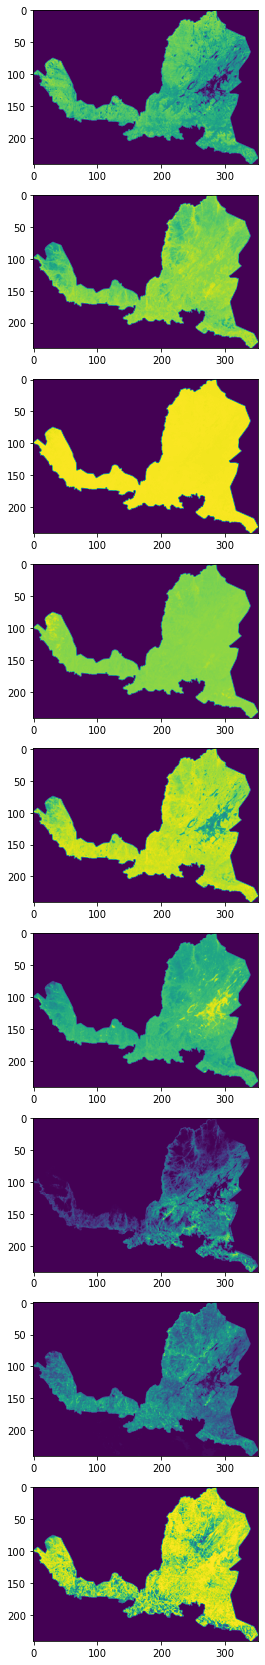

In [12]:
fig, axs = plt.subplots(Fc.shape[0],1,figsize=(15,30))
for i, ax in enumerate(axs):
    ax.imshow(FcF[i,::])

## Classification

In [17]:
import pandas as pd

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                            cohen_kappa_score,
                            make_scorer)
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from pprint import pprint

from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import dask.array as da

In [18]:
df = pd.read_csv(r'E:\mikkoi\lappi-eo\train.csv')
df

Invluokka  band0  band1  band2  band3  band4  band5  band6  band7  band8
0           241     44    147    245    133    161    152      4     19      3
1           241     42    145    244    133    159    150     10     20      3
2           242     43    152    244    134    163    154     42     23      3
3           242     44    158    244    134    170    164     43     20      5
4           242     45    174    243    135    176    175     68     24      5
...         ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
3333        263     47    189    242    151    171    179     87     42      5
3334        263     51    190    243    147    178    175     88     41      5
3335        251     42    168    243    139    172    165    114     34      5
3336        251     46    175    244    141    174    173    104     37      5
3337        241     57    169    242    136    165    171     71     13      5

[3338 rows x 10 columns]

In [19]:
# Read csv
dfY = df.iloc[:,0]
dfX = df.iloc[:,1:]

# Print info
print("Columns. First one is chosen as target")
print("Index\t\tColumn")
for i, col in enumerate(df.columns):
    print(f"{i}\t\t{col}")
print()

print("\nTarget class distribution")
print("label\tcount")
print(dfY.value_counts())
print()

# Classes smaller than 6 are removed
drop_classes = dfY.value_counts()[dfY.value_counts()<6].index.values
drop_series = ~dfY.isin(drop_classes)

dfY = dfY.loc[drop_series]
dfX = dfX.loc[drop_series,:]

print("Classes smaller than 6 are removed:")
print(drop_classes)
print()

# Final dataset
X = dfX.to_numpy(dtype=xds.dtype)
y = dfY.to_numpy(dtype=xds.dtype)

le = LabelEncoder()
y = le.fit_transform(y)

print(f"Shape of X: {X.shape}")
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('label mapping:')
pprint(le_name_mapping)

Columns. First one is chosen as target
Index		Column
0		Invluokka
1		band0
2		band1
3		band2
4		band3
5		band4
6		band5
7		band6
8		band7
9		band8


Target class distribution
label	count
242    937
241    683
251    244
263    196
232    194
333    156
323    114
321    108
104    104
262    103
252    102
430     60
271     48
999     47
332     37
101     37
261     37
312     33
313     28
322     22
331     20
311      6
220      6
335      3
105      2
422      2
231      2
324      2
102      2
334      1
336      1
410      1
Name: Invluokka, dtype: int64

Classes smaller than 6 are removed:
[335 105 422 231 324 102 334 336 410]

Shape of X: (3322, 9)
label mapping:
{5: 0,
 6: 1,
 7: 2,
 15: 3,
 55: 4,
 56: 5,
 57: 6,
 65: 7,
 66: 8,
 67: 9,
 75: 10,
 76: 11,
 77: 12,
 101: 13,
 104: 14,
 174: 15,
 220: 16,
 231: 17,
 232: 18,
 241: 19,
 242: 20,
 251: 21,
 252: 22}


In [20]:
# Ranfom forest validation
import sklearn.ensemble as ensemble
seed = 42

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)

scoring= {'accuracy': make_scorer(accuracy_score),
          'f1': make_scorer(f1_score, zero_division=0, average='weighted'),
          'precision': make_scorer(precision_score, zero_division=0, average='weighted'),
          'kappa': make_scorer(cohen_kappa_score)
         }

clf = RandomForestClassifier()
scores = cross_validate(clf, X, y, 
                     scoring=scoring,
                     cv=skf,
                     return_estimator=True,
                     verbose=2,
                     n_jobs=-1)
print(clf)
scores = pd.DataFrame(scores).drop(['fit_time', 'score_time', 'estimator'],axis=1)
print(scores.describe())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    8.9s remaining:    0.7s


RandomForestClassifier()
       test_accuracy    test_f1  test_precision  test_kappa
count      25.000000  25.000000       25.000000   25.000000
mean        0.577123   0.550755        0.548302    0.493769
std         0.018623   0.020333        0.023126    0.022719
min         0.539157   0.504545        0.495791    0.446356
25%         0.566265   0.538965        0.533660    0.479040
50%         0.576807   0.551788        0.550835    0.493117
75%         0.590361   0.568664        0.569951    0.511744
max         0.608434   0.586573        0.590302    0.533187


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished


In [21]:
# TPOT autoML
# Instructions:
# The TPOT script creates a python file with the model specifications. Copy the imports and the
# 'exported_pipeline' and 'set_param_recursive' -definitions here

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVC
from tpot.builtins import StackingEstimator, ZeroCount
from xgboost import XGBClassifier
from tpot.export_utils import set_param_recursive


# Average CV score on the training set was: 0.5210160197833493
exported_pipeline = make_pipeline(
    ZeroCount(),
    StackingEstimator(estimator=LinearSVC(C=20.0, dual=True, loss="squared_hinge", penalty="l2", tol=1e-05)),
    XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.7500000000000001, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [22]:
# Evaluation of the exported TPOT
scores = cross_validate(exported_pipeline, X, y, 
                     scoring=scoring,
                     cv=skf,
                     return_estimator=True,
                     verbose=2,
                     n_jobs=-1)
print(clf)
scores = pd.DataFrame(scores).drop(['fit_time', 'score_time', 'estimator'],axis=1)
print(scores.describe())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   25.3s remaining:    2.1s


RandomForestClassifier()
       test_accuracy    test_f1  test_precision  test_kappa
count      25.000000  25.000000       25.000000   25.000000
mean        0.571584   0.548585        0.545224    0.488243
std         0.018145   0.019269        0.020727    0.022329
min         0.519578   0.492243        0.483304    0.422793
25%         0.560241   0.534589        0.535238    0.474289
50%         0.571429   0.550973        0.549562    0.488651
75%         0.581325   0.560992        0.556029    0.503665
max         0.599398   0.577254        0.576631    0.521677


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   28.0s finished


In [23]:
from dask_ml.wrappers import ParallelPostFit

# Choose the better model here
#clf_rf = ParallelPostFit(estimator=RandomForestClassifier(n_jobs=threads_per_worker))
clf_rf = ParallelPostFit(estimator=exported_pipeline)

clf_rf.fit(X, y)

E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ParallelPostFit(estimator=Pipeline(steps=[('zerocount', ZeroCount()),
                                          ('stackingestimator',
                                           StackingEstimator(estimator=LinearSVC(C=20.0,
                                                                                 random_state=42,
                                                                                 tol=1e-05))),
                                          ('xgbclassifier',
                                           XGBClassifier(base_score=0.5,
                                                         booster='gbtree',
                                                         colsample_bylevel=1,
                                                         colsample_bynode=1,
                                                         colsample_bytree=1,
                                                         enable_categorical=False,
                                                         gamma=0, gpu_id=-1,
                                                         importance_type=None,
                                                         in...ts='',
                                                         learning_rate=0.1,
                                                         max_delta_step=0,
                                                         max_depth=4,
                                                         min_child_weight=2,
                                                         missing=nan,
                                                         monotone_constraints='()',
                                                         n_estimators=100,
                                                         n_jobs=1,
                                                         num_parallel_tree=1,
                                                         objective='multi:softprob',
                                                         predictor='auto',
                                                         random_state=42,
                                                         reg_alpha=0,
                                                         reg_lambda=1,
                                                         scale_pos_weight=None,
                                                         subsample=0.7500000000000001,
                                                         tree_method='exact',
                                                         validate_parameters=1,
                                                         verbosity=0))]))

## Inference

In [29]:

#ypos = 11000
#xpos = 24000

ypos = 1500
xpos = 24000

ypos = 0
xpos = 0

s = 2000
Ax = xds[:,ypos:ypos+s,xpos:xpos+s]
A = da.asarray(Ax)
Ax

<xarray.DataArray (band: 9, y: 2000, x: 2000)>
dask.array<getitem, shape=(9, 2000, 2000), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9
  * x            (x) float64 2.43e+05 2.43e+05 2.43e+05 ... 2.59e+05 2.59e+05
  * y            (y) float64 7.777e+06 7.777e+06 ... 7.761e+06 7.761e+06
    spatial_ref  int32 0
Attributes:
    LAYER_TYPE:                 athematic
    OVERVIEWS_ALGORITHM:        ErdasBino3
    STATISTICS_EXCLUDEDVALUES:  0
    STATISTICS_HISTOBINVALUES:  15358926|8631097|4623772|2336732|1288940|8877...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        1
    STATISTICS_HISTONUMBINS:    255
    STATISTICS_MAXIMUM:         255
    STATISTICS_MEAN:            37.508722451931
    STATISTICS_MEDIAN:          41
    STATISTICS_MINIMUM:         1
    STATISTICS_MODE:            44
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          11.749587979338
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  ('Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', ...

In [30]:
ypos = 2000
xpos = 33000 # 24000 or 18000
s = 4000
Bx = xds[:,ypos:ypos+s,xpos:xpos+s]
B = da.asarray(Bx)
B

dask.array<getitem, shape=(9, 4000, 4000), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

In [31]:
F = da.asarray(xds)
F

dask.array<open_rasterio-770c9b3d55c2543b72d0965b45d9e3a4<this-array>, shape=(9, 30962, 45136), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

In [32]:
y_half = F.shape[1]//2
x_half = F.shape[2]//2

F1 = F[:,:y_half,:x_half]
F2 = F[:,y_half:,:x_half]
F3 = F[:,:y_half,x_half:]
F4 = F[:,y_half:,x_half:]
F1

dask.array<getitem, shape=(9, 15481, 22568), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

In [33]:
def da_coarsen(x, maxlen=200):
    cc = int(np.max(x.shape)/maxlen)
    return da.coarsen(np.mean, x, {0:cc, 1:cc}, trim_excess=True)

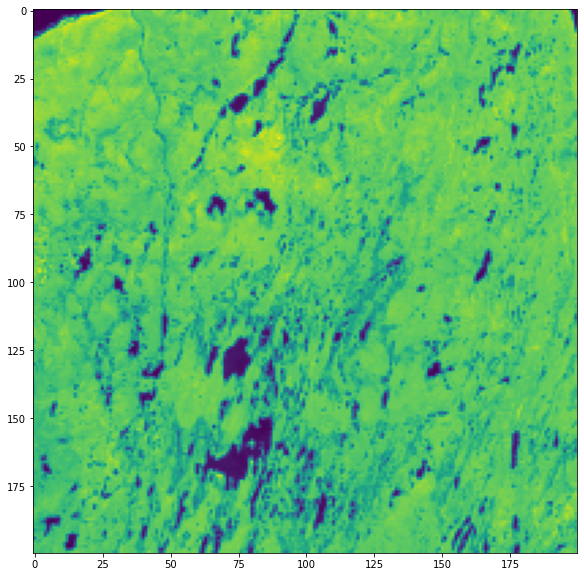

In [34]:
fig,ax = plt.subplots(figsize=(20,10))
B0 = da_coarsen(B[0]).compute()
ax.imshow(B0)

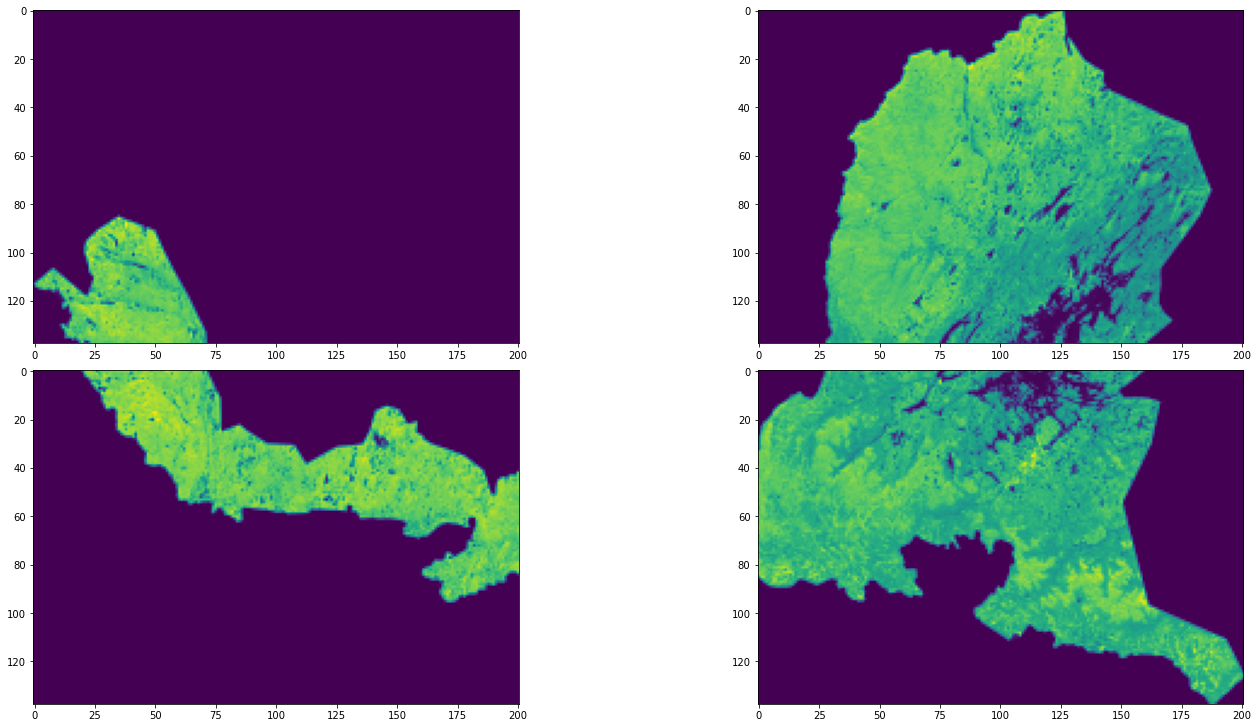

In [25]:
mosaic = """
    AC
    BD
    """
fig = plt.figure(figsize=(20,10), constrained_layout=True)
ad = fig.subplot_mosaic(mosaic)

F10 = da_coarsen(F1[0]).compute()
F20 = da_coarsen(F2[0]).compute()
F30 = da_coarsen(F3[0]).compute()
F40 = da_coarsen(F4[0]).compute()

ad['A'].imshow(F10)
ad['B'].imshow(F20)
ad['C'].imshow(F30)
ad['D'].imshow(F40)

In [35]:
from skimage.color import label2rgb

def full_inference(A: dask.array) -> dask.array:
    # Reshaping
    A0 = da.moveaxis(A,0,2)
    ny, nx, chan = A0.shape
    a = A0.reshape(ny*nx, chan)

    # Classification
    c0 = clf.predict_proba(a)
    c = (254*c0).astype(np.uint8)

    # Inverse reshaping
    C = c.reshape(ny,nx, -1)
    C = da.moveaxis(C,2,0)
 
    return C

def inference(a: dask.array, clf) -> dask.array:
    c0 = clf.predict_proba(a)
    c = (254*c0).astype(np.uint8)
    return c

def read_masked_data(A: dask.array):
    """ Picks nonzero values along depth from A and returns rows of nonzero values
    and their index mask
    
    Performance depends highly on the mask rechunking size. If the chunk size is too large, memory 
    use per worker is too high, and if it is too low, chunks are probably copied across workers so
    that system memory usage is too high and SLURM job crashes.
    
    params
    A : array
    
    returns
    data: nonzero rows
    mask: row locations
    """

    A0 = da.moveaxis(A,0,2)
    ny, nx, chan = A0.shape
    a = A0.reshape(ny*nx, chan)

    mask = da.where(~da.all(a==0,axis=1))[0]
    mask.compute_chunk_sizes()
    mask = mask.rechunk((1e6,-1)) #inference float chunks get too big otherwise
    
    data = a[mask,:]
    return data, mask

def masked_inference(A: dask.array, clf)->dask.array:
    """Classifies an array depth-wise 
    """
    
    # Masking
    data, mask = read_masked_data(A)
    
    # New data
    chan, ny, nx = A.shape
    c = da.zeros((ny*nx, len(clf.classes_)), dtype=np.uint8) #empty array for results
    
    # Inference
    if len(data)!=0:
        c0 = inference(data, clf)
        c[mask,:] = c0

    # Inverse reshape
    C = c.reshape(ny,nx, -1)
    C = da.moveaxis(C,2,0)
    
    return C

In [36]:
clf = clf_rf.estimator
classes = le.inverse_transform(clf.classes_)
clf

Pipeline(steps=[('zerocount', ZeroCount()),
                ('stackingestimator',
                 StackingEstimator(estimator=LinearSVC(C=20.0, random_state=42,
                                                       tol=1e-05))),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None,
                               subsample=0.7500000000000001,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

In [37]:
Cb = B.map_blocks(lambda x: masked_inference(x, clf), dtype=dask.array.core.Array)
Cb

dask.array<lambda, shape=(9, 4000, 4000), dtype=object, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

In [38]:
Cb = Cb.persist()
Cb

dask.array<lambda, shape=(9, 4000, 4000), dtype=object, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

In [40]:
Cb

dask.array<lambda, shape=(9, 4000, 4000), dtype=object, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

In [42]:
%%time
Cb = masked_inference(B, clf)
Cb

E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\dask\array\slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 16
  p = blockwise(


MemoryError: Unable to allocate 2.74 GiB for an array with shape (15967795, 23) and data type float64

In [63]:
Cb = Cb.persist()

In [132]:
C1 = masked_inference(F1, clf)
C1

/users/impiomik/.local/lib/python3.9/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 35
  p = blockwise(


dask.array<transpose, shape=(25, 17298, 25222), dtype=uint8, chunksize=(25, 186, 25222), chunktype=numpy.ndarray>

In [134]:
C2 = masked_inference(F2, clf)
C2

/users/impiomik/.local/lib/python3.9/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 102
  p = blockwise(
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if (await self.run_code(code, result,  async_=asy)):


dask.array<transpose, shape=(25, 17299, 25222), dtype=uint8, chunksize=(25, 213, 25222), chunktype=numpy.ndarray>

In [133]:
C3 = masked_inference(F3, clf)
C3

/users/impiomik/.local/lib/python3.9/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 117
  p = blockwise(


dask.array<transpose, shape=(25, 17298, 25223), dtype=uint8, chunksize=(25, 186, 25223), chunktype=numpy.ndarray>

In [136]:
C4 = masked_inference(F4, clf)
C4

/users/impiomik/.local/lib/python3.9/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 117
  p = blockwise(
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if (await self.run_code(code, result,  async_=asy)):


dask.array<transpose, shape=(25, 17299, 25223), dtype=uint8, chunksize=(25, 213, 25223), chunktype=numpy.ndarray>

In [137]:
%%time
C1 = C1.persist()
progress(C1)
_ = wait(C1)

CPU times: user 57.8 s, sys: 8.62 s, total: 1min 6s
Wall time: 1min 44s


In [ ]:
%%time
C2 = C2.persist()
progress(C2)
_ = wait(C2)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distribu

In [ ]:
%%time
C3 = C3.persist()
progress(C3)
_ = wait(C3)

In [ ]:
%%time
C4 = C4.persist()
progress(C4)
_ = wait(C4)

In [ ]:
CF = da.concatenate(
        (da.concatenate((C1,C2),axis=1), 
         da.concatenate((C3,C4),axis=1)), 
        axis=2).rechunk((-1, chunk_s, chunk_s))
CF

In [ ]:
%%time
CF = CF.persist()
progress(CF)
_ = wait(CF)

In [64]:
Cb = Cb.rechunk((-1, chunk_s, chunk_s)).persist()
Cb

dask.array<transpose, shape=(23, 2000, 2000), dtype=uint8, chunksize=(23, 2000, 2000), chunktype=numpy.ndarray>

In [87]:
from datetime import datetime
t = datetime.now()

In [41]:
C = Cb
S = da_coarsen(C.argmax(axis=0), 2000)
M = da_coarsen(C.max(axis=0), 2000)

Sc = S.compute()
Mc = M.compute()

fig, ax = plt.subplots(2,1, figsize=(15,30))
ax[0].imshow(label2rgb(Sc, bg_label=-1))
ax[1].imshow(Mc)

Task exception was never retrieved
future: <Task finished name='Task-29261' coro=<Client._gather.<locals>.wait() done, defined at E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\distributed\client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\distributed\client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-29262' coro=<Client._gather.<locals>.wait() done, defined at E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\distributed\client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "E:\anaconda\anaconda3\envs\mikko-lappieo-no-dl\lib\site-packages\distributed\client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-29266' coro=<Client._gather.<locals>.wait() don

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [49]:
Sb = Cb.argmax(axis=0).astype(np.uint8)
Mb = Cb.max(axis=0)
Sb

dask.array<astype, shape=(4000, 4000), dtype=uint8, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [50]:
S = CF.argmax(axis=0).astype(np.uint8)
M = CF.max(axis=0)
S

dask.array<astype, shape=(34624, 50474), dtype=uint8, chunksize=(2048, 2048), chunktype=numpy.ndarray>

## Saving

In [51]:
new_3d_xda = lambda c, d: xr.DataArray(c, 
                                       name='classification', 
                                       coords={'class': np.arange(len(classes)), 
                                               'y': d.y, 
                                               'x': d.x},
                                       dims=('class', 'y', 'x'))
new_2d_xda = lambda c, d: xr.DataArray(c, 
                                       coords={'y': d.y, 
                                               'x': d.x}, 
                                       dims=('y', 'x'))

In [110]:
outB = new_3d_xda(Cb.rechunk((-1,chunk_s, chunk_s)), Bx)
outB

<xarray.DataArray 'classification' (class: 25, y: 4000, x: 4000)>
dask.array<rechunk-merge, shape=(25, 4000, 4000), dtype=uint8, chunksize=(25, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * class    (class) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
  * y        (y) float64 7.762e+06 7.762e+06 7.762e+06 ... 7.734e+06 7.734e+06
  * x        (x) float64 4.791e+05 4.791e+05 4.791e+05 ... 5.077e+05 5.077e+05

In [52]:
outF = new_3d_xda(CF, xds)
outS = new_2d_xda(S, xds)
outM = new_2d_xda(M, xds)
outF

<xarray.DataArray 'classification' (class: 25, y: 34624, x: 50474)>
dask.array<rechunk-merge, shape=(25, 34624, 50474), dtype=uint8, chunksize=(25, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * class    (class) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
  * y        (y) float64 7.777e+06 7.777e+06 7.777e+06 ... 7.529e+06 7.529e+06
  * x        (x) float64 2.43e+05 2.43e+05 2.43e+05 ... 6.041e+05 6.041e+05

In [65]:
save_raster = lambda da, name: da.rio.to_raster(name, 
                                   compress='LZW',
                                   crs="epsg:3067",
                                   tiled=True,
                                   lock=Lock("rio", client=client))

In [66]:
save_raster(Bx, 'B_test.tif')

In [112]:
save_raster(outB, 'B_random_opt.tif')

In [54]:
save_raster(outF, 'RF_classification.tif')
save_raster(outS, 'RF_classification_S.tif')
save_raster(outM, 'RF_classification_M.tif')

In [61]:
bands = zip(np.arange(1,29), classes)

In [62]:
from osgeo import gdal
ds = gdal.Open('RF_classification.tif', gdal.GA_Update)
for band, desc in bands:
    rb = ds.GetRasterBand(int(band))
    rb.SetDescription(desc)
del ds

TypeError: in method 'MajorObject_SetDescription', argument 2 of type 'char const *'

In [63]:
client.close()

In [66]:
import gc
client.run(gc.collect)

{'tcp://127.0.0.1:59123': 479,
 'tcp://127.0.0.1:59129': 223,
 'tcp://127.0.0.1:59132': 610}